In [1]:
import jax
jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_debug_nans", True)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax.numpy as jnp
import jax.random as jrng
import jax.scipy as jsp
import numpy as np
import ultraplot as uplt

In [4]:
import scipy as sp

MIN = -2
MAX = 2

TRUE_LOG_Z = np.log((sp.stats.norm.cdf(MAX) - sp.stats.norm.cdf(MIN))/4)


def _neg_log_like_gauss1d(x, sigma, mu=0.0):
    return 0.5 * jnp.sum((x-mu)**2) / sigma**2 + jnp.log(sigma) + 0.5 * jnp.log(2.0 * jnp.pi)

def _neg_log_like(x):
    # y = x[0]
    # x = x[1:]
    # return _neg_log_like_gauss1d(y, 3) + _neg_log_like_gauss1d(x, jnp.exp(y / 2))
    # return _neg_log_like_gauss1d(y, 3) + _neg_log_like_gauss1d(x, 200)

    # return jnp.sum(((1 - y)**2 + 100.0 * (x - y**2)**2) / 20)

    # return (jnp.sum(x**2) - 1)**2 / 0.25**2

    return _neg_log_like_gauss1d(x, 1)
    # return -1.0 * jsp.special.logsumexp(
    #     jnp.array([
    #         -_neg_log_like_gauss1d(x, 0.25) + jnp.log(0.25),
    #         -_neg_log_like_gauss1d(x, 1, mu=2) + jnp.log(0.75),
    #     ])
    # )


def _log_like(x):
    return -1.0 * _neg_log_like(x)


def _prior_draw(rng_key):
    return jrng.uniform(rng_key, shape=(1,), minval=MIN, maxval=MAX)


def _constrained_sampler(rng_key, ns_data, dead_index):
    dead_point = ns_data.live_points.theta[dead_index, :]
    nan_live_points = ns_data.live_points.theta.at[dead_index, :].set(dead_point + jnp.nan)
    minval = jnp.nanmin(nan_live_points, axis=0)
    maxval = jnp.nanmax(nan_live_points, axis=0)

    for i in range(10):
        rng_key, samp_key = jrng.split(rng_key)
        draw = jrng.uniform(samp_key, shape=dead_point.shape, minval=minval, maxval=maxval)
        log_like = _log_like(draw)

        if log_like > ns_data.min_loglike:
            break

    if i == 9:
        assert False, "Did not draw!"

    return draw

In [6]:
from nested_sampling import nested_sampler

rng_key = jrng.PRNGKey(seed=2143)
n_dims = 1
n_live = 10000
n_iter_max = 100000
n_iter_conv_fac = 20

(logZ, delta_logZ, samps, logw, loglike, ns_data) = nested_sampler(
    rng_key,
    _log_like,
    _prior_draw,
    _constrained_sampler,
    n_dims,
    n_live,
    n_iter_max,
    n_iter_conv_fac,
)
print("logZ|err:", logZ, delta_logZ)
print("true logZ:", TRUE_LOG_Z)
print("H:", ns_data.H)

sampling (logZ: -1.50083e+00): 100%|████▉| 33291/33292 [01:14<00:00, 446.90it/s]


logZ|err: -1.4387528897960538 0.004297535311978147
true logZ: -1.432862273412281
H: 0.16645447995802964


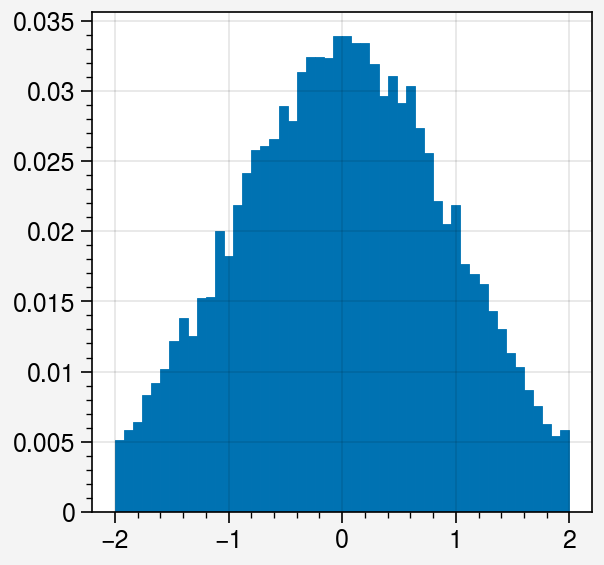

In [7]:
fig, axs = uplt.subplots()

wgts = jnp.exp(logw)
axs.hist(samps[:, 0], weights=wgts, bins=50);

In [8]:
import tensorflow_probability.substrates.jax as tfp
from jax import random
from jaxns import Prior, Model
from jaxns import NestedSampler

tfpd = tfp.distributions

def prior_model():
    x = yield Prior(tfpd.Uniform(MIN, MAX), name='x')
    return x


model = Model(
    prior_model=prior_model,
    log_likelihood=_log_like
)

exact_ns = NestedSampler(model=model, max_samples=1e4, c=100)

termination_reason, state = exact_ns(random.PRNGKey(42))
results = exact_ns.to_results(termination_reason=termination_reason, state=state)

exact_ns.summary(results)

--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 32386
samples: 850
phantom samples: 0
likelihood evals / sample: 38.1
phantom fraction (%): 0.0%
--------
logZ=-1.412 +- 0.047
max(logL)=-0.919
H=-0.14
ESS=103
--------
x: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x: 0.22 +- 0.8 | -0.89 / 0.2 / 1.44 | -0.0 | -0.0
--------
